# EEG data pre-processing

Imports

In [1]:
import os
import logging
import mne
import numpy as np
import sys
from autoreject import AutoReject
from mne.utils import set_log_file
import pandas as pd
import pickle

In [2]:
logger_errors = logging.getLogger('errors')
logger_errors.setLevel(logging.INFO)

### Preprocessing

In [242]:
unified_events_dict = {
    'Stimulus/GO*0*0.1*L*-': 1101,
    'Stimulus/GO*0*0.1*L*L': 1100,
    'Stimulus/GO*0*0.1*R*-': 1101,
    'Stimulus/GO*0*0.1*R*R': 1100,
    
    'Stimulus/GO*0*0.15*L*-': 1151,
    'Stimulus/GO*0*0.15*L*L': 1150,
    'Stimulus/GO*0*0.15*R*-': 1151,
    'Stimulus/GO*0*0.15*R*R': 1150,
    
    'Stimulus/GO*0*0.2*L*-': 1201,
    'Stimulus/GO*0*0.2*L*L': 1200,
    'Stimulus/GO*0*0.2*R*-': 1201,
    'Stimulus/GO*0*0.2*R*R': 1200,
    
    'Stimulus/GO*0*0.25*L*-': 1251,
    'Stimulus/GO*0*0.25*L*L': 1250,
    'Stimulus/GO*0*0.25*R*-': 1251,
    'Stimulus/GO*0*0.25*R*R': 1250,
    
    'Stimulus/GO*0*0.3*L*-': 1301,
    'Stimulus/GO*0*0.3*L*L': 1300,
    'Stimulus/GO*0*0.3*R*-': 1301,
    'Stimulus/GO*0*0.3*R*R': 1300,
    
    'Stimulus/GO*0*0.35*L*-': 1351,
    'Stimulus/GO*0*0.35*L*L': 1350,
    'Stimulus/GO*0*0.35*R*-': 1351,
    'Stimulus/GO*0*0.35*R*R': 1350,
    
    'Stimulus/GO*0*0.4*L*-': 1401,
    'Stimulus/GO*0*0.4*L*L': 1400,
    'Stimulus/GO*0*0.4*R*-': 1401,
    'Stimulus/GO*0*0.4*R*R': 1400,

    'Stimulus/ST*0*0.1*L*-': 2101,
    'Stimulus/ST*0*0.1*L*L': 2100,
    'Stimulus/ST*0*0.1*R*-': 2101,
    'Stimulus/ST*0*0.1*R*R': 2100,
    
    'Stimulus/ST*0*0.15*L*-': 2151,
    'Stimulus/ST*0*0.15*L*L': 2150,
    'Stimulus/ST*0*0.15*R*-': 2151,
    'Stimulus/ST*0*0.15*R*R': 2150,
    
    'Stimulus/ST*0*0.2*L*-': 2201,
    'Stimulus/ST*0*0.2*L*L': 2200,
    'Stimulus/ST*0*0.2*R*-': 2201,
    'Stimulus/ST*0*0.2*R*R': 2200,

    'Stimulus/ST*0*0.25*L*-': 2251,
    'Stimulus/ST*0*0.25*L*L': 2250,
    'Stimulus/ST*0*0.25*R*-': 2251,
    'Stimulus/ST*0*0.25*R*R': 2250,

    'Stimulus/ST*0*0.3*L*-': 2301,
    'Stimulus/ST*0*0.3*L*L': 2300,
    'Stimulus/ST*0*0.3*R*-': 2301,
    'Stimulus/ST*0*0.3*R*R': 2300,

    'Stimulus/ST*0*0.35*L*-': 2351,
    'Stimulus/ST*0*0.35*L*L': 2350,
    'Stimulus/ST*0*0.35*R*-': 2351,
    'Stimulus/ST*0*0.35*R*R': 2350,

    'Stimulus/ST*0*0.4*L*-': 2401,
    'Stimulus/ST*0*0.4*L*L': 2400,
    'Stimulus/ST*0*0.4*R*-': 2401,
    'Stimulus/ST*0*0.4*R*R': 2400,

    'Stimulus/RE*0*0.1*L*L': 3100,
    'Stimulus/RE*0*0.1*R*R': 3100,
    
    'Stimulus/RE*0*0.15*L*L': 3150,
    'Stimulus/RE*0*0.15*R*R': 3150,
    
    'Stimulus/RE*0*0.2*L*L': 3200,
    'Stimulus/RE*0*0.2*R*R': 3200,
    
    'Stimulus/RE*0*0.25*L*L': 3250,
    'Stimulus/RE*0*0.25*R*R': 3250,
    
    'Stimulus/RE*0*0.3*L*L': 3300,
    'Stimulus/RE*0*0.3*R*R': 3300,
    
    'Stimulus/RE*0*0.35*L*L': 3350,
    'Stimulus/RE*0*0.35*R*R': 3350,
    
    'Stimulus/RE*0*0.4*L*L': 3400,
    'Stimulus/RE*0*0.4*R*R': 3400, 
}

go_events_dict = {
    'Stimulus/GO*0*0.1*L*-': 1101,
    'Stimulus/GO*0*0.1*L*L': 1100,
    'Stimulus/GO*0*0.1*R*-': 1101,
    'Stimulus/GO*0*0.1*R*R': 1100,
    
    'Stimulus/GO*0*0.15*L*-': 1151,
    'Stimulus/GO*0*0.15*L*L': 1150,
    'Stimulus/GO*0*0.15*R*-': 1151,
    'Stimulus/GO*0*0.15*R*R': 1150,
    
    'Stimulus/GO*0*0.2*L*-': 1201,
    'Stimulus/GO*0*0.2*L*L': 1200,
    'Stimulus/GO*0*0.2*R*-': 1201,
    'Stimulus/GO*0*0.2*R*R': 1200,
    
    'Stimulus/GO*0*0.25*L*-': 1251,
    'Stimulus/GO*0*0.25*L*L': 1250,
    'Stimulus/GO*0*0.25*R*-': 1251,
    'Stimulus/GO*0*0.25*R*R': 1250,
    
    'Stimulus/GO*0*0.3*L*-': 1301,
    'Stimulus/GO*0*0.3*L*L': 1300,
    'Stimulus/GO*0*0.3*R*-': 1301,
    'Stimulus/GO*0*0.3*R*R': 1300,
    
    'Stimulus/GO*0*0.35*L*-': 1351,
    'Stimulus/GO*0*0.35*L*L': 1350,
    'Stimulus/GO*0*0.35*R*-': 1351,
    'Stimulus/GO*0*0.35*R*R': 1350,
    
    'Stimulus/GO*0*0.4*L*-': 1401,
    'Stimulus/GO*0*0.4*L*L': 1400,
    'Stimulus/GO*0*0.4*R*-': 1401,
    'Stimulus/GO*0*0.4*R*R': 1400,
}

In [243]:
def preprocess_file(file_path, n_jobs=10, random_state=42):
  raw = mne.io.read_raw_brainvision(
        file_path,
        preload=True,
        eog = ['HEOG', 'VEOG', 'EXG1', 'EXG2','EXG3','EXG4'],
        
  )

  # 1. Segmentation
  all_events, all_event_ids = mne.events_from_annotations(raw, unified_events_dict)
    
  tmin = -0.9
  tmax = 1.099
  baseline = None

  epochs = mne.Epochs(
      raw = raw,
      events=all_events,
      event_id=go_events_dict,
      tmin=tmin,
      tmax=tmax,
      baseline=baseline,
      reject_by_annotation=False,
      preload=True,
      reject=None,
      picks=['eeg', 'eog'],
      on_missing = 'warn',
  )

  # 3. Artifact correction with autoreject
  ar = AutoReject(random_state=random_state, n_jobs=n_jobs, verbose=0)
  epochs_ar = ar.fit_transform(epochs, return_log=False)

  return epochs_ar, all_events

Set parameters

In [244]:
random_state=42
n_jobs = 10

Perform proprocessing

In [ ]:
data_dir = '../data/Export_SST_EEGNet' # change to your dir
output_dir = '../pre_processed_data/' # change to your dir

# read all .vhdr files from dir path
vhdr_files = [f for f in os.listdir(data_dir) if f.endswith(".vhdr")]

# exclude already pre-processed files
pre_processed_files = [f.replace("-epo.fif", ".vhdr") for f in os.listdir(output_dir) if f.endswith(".fif")]
current_files = [f for f in vhdr_files if f not in pre_processed_files]

for file_name in current_files:
  vhdr_path = os.path.join(data_dir, file_name)

  try:
    pre_processed_epochs, events = preprocess_file(vhdr_path, n_jobs=n_jobs, random_state=random_state)
    
    # save pre-processed epochs
    pre_processed_epochs.save(f"{output_dir}/{file_name[:-5]}-epo.fif", overwrite=True)

    # pickle events from original signal
    with open(f"{output_dir}/{file_name[:-5]}-events.pkl", "wb") as f:
        pickle.dump(events, f)

  except Exception as e:
    logger_errors.error(f"{e}")

### Summary of the individual-leve data

In [7]:
def find_trial_events(
    events_original, 
    events_clean, 
    stop_events_ids, 
    response_events_ids
):
    data = []
    
    epochs_numbers = []
    stop_events = []
    go_events = []
    response_events = []
    
    for epoch_index, event in enumerate(events_clean):
    
        # Find the index of the current event in events_original
        original_event_idx = np.where((events_original == event).all(axis=1))[0]
    
        if original_event_idx.size == 0:
            print(f"Warning: Event {event} not found in events_original!")
            continue  # Skip if event is not found
    
        original_event_idx = original_event_idx[0]  # Extract first occurrence
    
        # Ensure there's a next event
        if original_event_idx + 1 < len(events_original):
            next_event = events_original[original_event_idx + 1]
            next_event_id = next_event[-1]
    
            # Check if the next event is a STOP event
            if next_event_id in stop_events_ids:

                if str(next_event_id)[-1] == '0': # uninhibited
                    response_event = events_original[original_event_idx + 2]
                    response_event_id = response_event[-1]
                    
                    if response_event_id in response_events_ids:
                        assert str(event[-1])[1:3] == str(next_event[-1])[1:3] == str(response_event[-1])[1:3]

                        epochs_numbers.append(epoch_index)
                        stop_events.append(next_event)
                        go_events.append(event)
                        response_events.append(response_event)

                    else:
                        print(f"Warning: After uninhibited stop event {next_event}: {response_event} not in RESPONSE!")
                        epochs_numbers.append(epoch_index)
                        stop_events.append([np.nan, np.nan, np.nan])
                        go_events.append([np.nan, np.nan, np.nan])
                        response_events.append([np.nan, np.nan, np.nan])

                else: # inhibited
                    assert str(event[-1])[1:3] == str(next_event[-1])[1:3]
                    
                    epochs_numbers.append(epoch_index)
                    stop_events.append(next_event)
                    go_events.append(event)
                    response_events.append([np.nan, np.nan, np.nan])
                
            else:
                print(f"Warning: Next of {event}: {next_event} not in STOP!")
                epochs_numbers.append(epoch_index)
                stop_events.append([np.nan, np.nan, np.nan])
                go_events.append([np.nan, np.nan, np.nan])
                response_events.append([np.nan, np.nan, np.nan])

    
    stop_events = np.array(stop_events)
    go_events = np.array(go_events)
    response_events = np.array(response_events)
    
    assert len(stop_events)==len(go_events)==len(epochs_numbers)==len(response_events)

    return go_events, stop_events, response_events, epochs_numbers


def create_trials_df(epochs_clean, epoch_start, events_original, events_clean, stop_events_ids, response_events_ids, max_len=0.8):
    """
    Create a DataFrame with trial event information.

    Parameters:
        epochs_clean (mne.Epochs): Cleaned EEG epochs.
        epoch_start (float): Start time of epochs.
        events_original (np.ndarray): The full event list.
        events_clean (np.ndarray): The subset of events after preprocessing.
        stop_events_ids (set or list): Identifiers for STOP events.
        response_events_ids (set or list): Identifiers for RESPONSE events.
        max_len (float): Maximum valid GO-STOP duration (in seconds).

    Returns:
        pd.DataFrame: A DataFrame containing GO, STOP, and RESPONSE event details.
    """
    go_events, stop_events, response_events, epochs_numbers = find_trial_events(
        events_original, events_clean, stop_events_ids, response_events_ids
    )

    epochs_clean_data = epochs_clean.get_data(picks='eeg')[epochs_numbers]
    assert len(epochs_clean_data) == len(epochs_numbers)

    sfreq = epochs_clean.info['sfreq']
    go_tp = int(abs(epoch_start) * sfreq)

    # Compute Stop-Signal Delay (SSD)
    go_stop_dist = np.where(stop_events[:, 0] != None, stop_events[:, 0] - go_events[:, 0], None)
    stop_response_dist = np.where(response_events[:, 0] != None, response_events[:, 0] - stop_events[:, 0], None)

    assert (go_stop_dist <= sfreq * max_len).all()

    # Create DataFrame
    data_df = pd.DataFrame({
        'GO code': go_events[:, -1],
        'STOP code': stop_events[:, -1],
        'RESPONSE code': response_events[:, -1],
        'SSD tp': go_stop_dist,
        'SSD type': [str(event[-1])[1:3] if event[-1] is not None else None for event in stop_events],
        'SRI': stop_response_dist/sfreq,
        'GO tp': [go_tp] * len(go_events),
        'STOP tp': go_tp + go_stop_dist,
        'Epoch': [epoch.tolist() for epoch in epochs_clean_data],
        'Epoch number': epochs_numbers,
        'Trial type': [0 if str(trial_code)[-1] == '0' else 1 for trial_code in go_events[:, -1]]
    })

    return data_df    
    

def validate_subject(data_df, ignore_ssd=[], ignore_sri=0.0):
    """
    Validate the subject's data by filtering out invalid trials and summarizing trial types.

    Parameters:
    - data_df (pd.DataFrame): The input DataFrame containing trial data.
    - ignore_ssd (list of int): List of SSD values to ignore.

    Returns:
    - summary (dict): A dictionary with counts of each trial type.
    """
    
    # Filter out rows where 'GO code' is NaN
    filtered_df = data_df.dropna(subset=['GO code'])
    
    # Ignore rows where SSD is in ignore_ssd list
    filtered_df = filtered_df[~filtered_df['SSD type'].astype(float).isin(ignore_ssd)]
    
    # Ignore rows where SRI < ignore_sri
    filtered_df = filtered_df[filtered_df['SRI'].isna() | (filtered_df['SRI'] >= ignore_sri)]

    # Count the number of trials for each trial type
    trial_summary = filtered_df['Trial type'].value_counts().to_dict()

    return trial_summary, filtered_df


def create_go_stop_segments(
    data_df, 
    sfreq, 
    stop_start=0.0, 
    stop_stop=0.5, 
    go_start=-0.2, 
    go_stop=0.5
):
    stop_epochs = []
    go_epochs = []

    # stop_len_tp = int(stop_len * sfreq)

    # Iterate over rows of the dataframe
    for index, row in data_df.iterrows():
        epoch_data = np.array(row['Epoch'])  # Extract epoch data
        stop_idx = row['STOP tp']  # Get STOP event index (assuming it’s in time points)
        stop_start_tp = stop_idx + int(stop_start * sfreq)
        stop_stop_tp = stop_idx + int(stop_stop * sfreq)
        
        go_idx = row['GO tp']
        go_start_tp = go_idx+int(go_start*sfreq)
        go_stop_tp = go_idx+int(go_stop*sfreq)
        
        # Check if stop_idx is within bounds
        if stop_idx < epoch_data.shape[1]:
            stop_epoch = epoch_data[:, stop_start_tp:stop_stop_tp]
            stop_epochs.append(stop_epoch)
        else:
            print(f"Stop index {stop_idx} out of bounds for epoch at index {index}")

         # Check if go_idx is within bounds
        if go_idx < epoch_data.shape[1]:
            go_epoch = epoch_data[:, go_start_tp:go_stop_tp]
            go_epochs.append(go_epoch)
        else:
            print(f"Go index {go_idx} out of bounds for epoch at index {index}")
    
    stop_epochs = np.array(stop_epochs)
    go_epochs = np.array(go_epochs)

    assert go_epochs.shape[0] == stop_epochs.shape[0]
    go_stop_epochs = np.concatenate([go_epochs, stop_epochs], axis=-1)
    
    assert len(go_epochs) == len(stop_epochs) == len(data_df), f"Len of go and stop segments: {len(go_epochs)} not equals len of data: {len(data_df)}"

    go_stop_df = pd.DataFrame({
             'stop_epochs': [epoch.tolist() for epoch in stop_epochs],
             'go_epochs': [epoch.tolist() for epoch in go_epochs], 
             'go_stop_epochs': [epoch.tolist() for epoch in go_stop_epochs]
             })
    
    final_data_df = pd.concat([data_df.reset_index(drop=True), go_stop_df.reset_index(drop=True)], axis=1)


    return final_data_df

In [ ]:
input_dir = '../pre_processed_data'  # Change to your directory
stop_events_ids = [2101, 2100, 2151, 2150, 2201, 2200, 2251, 2250, 2301, 2300, 2351, 2350, 2401, 2400]
response_events_ids = [3100, 3150, 3200, 3250, 3300, 3350, 3400]

participants_summary = []
participants_data_dfs = []
ignore_ssd=[10]
ignore_sri=0.10
# Get all .fif files from the directory
eeg_files = [f for f in os.listdir(input_dir) if f.endswith("-epo.fif")]

# Loop through each .fif file and read epochs
for file_name in eeg_files:
    try:
        # Path to the epoch file
        epochs_path = os.path.join(input_dir, file_name)
        epochs = mne.read_epochs(epochs_path)  # Read the epochs from the .fif file
        print(f"Successfully loaded epochs from {file_name}")

        # Construct the matching events pickle file path
        events_pickle_path = epochs_path.replace("-epo.fif", "-events.pkl")

        # Check if the corresponding events pickle file exists
        if os.path.exists(events_pickle_path):
            with open(events_pickle_path, "rb") as f:
                events = pickle.load(f)  # Load events from the pickle file
            print(f"Successfully loaded events from {events_pickle_path}")


            events_clean = epochs.events
            events_original = events
            sfreq = epochs.info['sfreq']
            
            data_df = create_trials_df(
                epochs_clean=epochs, 
                epoch_start=-0.9, 
                events_original=events_original, 
                events_clean=events_clean, 
                stop_events_ids=stop_events_ids, 
                response_events_ids = response_events_ids,
                max_len=0.4*sfreq
            )
            
            subject_summary, _ = validate_subject(
                data_df, 
                ignore_ssd=ignore_ssd, 
                ignore_sri=ignore_sri
            )
            participants_summary.append(subject_summary)
            
        else:
            logger_errors.info(f"No events file found for {file_name}")

    except Exception as e:
        logger_errors.info(f"Error processing {file_name}: {e}")

In [5]:
# # min SSD > 100 ms; min SRI > 150 ms
# summary_all_participants = pd.DataFrame(participants_summary)

# display(summary_all_participants.describe())
# summary_all_participants.sum()

# # 0    3465
# # 1    7064
# # dtype: int64

In [9]:
# min SSD > 100 ms; min SRI > 100 ms
summary_all_participants = pd.DataFrame(participants_summary)

display(summary_all_participants.describe())
summary_all_participants.sum()

,0,1
count,225.000000,225.000000
mean,28.866667,31.395556
std,7.991066,14.828152
min,5.000000,3.000000
25%,23.000000,18.000000
50%,30.000000,32.000000
75%,34.000000,44.000000
max,44.000000,72.000000


0    6495
1    7064
dtype: int64

## Prepare data for fitting

In [10]:
input_dir = '../pre_processed_data'
output_data_dir = '../final_data'

stop_events_ids = [2101, 2100, 2151, 2150, 2201, 2200, 2251, 2250, 2301, 2300, 2351, 2350, 2401, 2400]
response_events_ids = [3100, 3150, 3200, 3250, 3300, 3350, 3400]

participants_data_dfs = []
ignore_ssd=[10]
ignore_sri=0.10
# Get all .fif files from the directory
eeg_files = [f for f in os.listdir(input_dir) if f.endswith("-epo.fif")]

# Loop through each .fif file and read epochs
for file_name in eeg_files:
    try:
        # Path to the epoch file
        epochs_path = os.path.join(input_dir, file_name)
        epochs = mne.read_epochs(epochs_path)  # Read the epochs from the .fif file
        print(f"Successfully loaded epochs from {file_name}")

        # Construct the matching events pickle file path
        events_pickle_path = epochs_path.replace("-epo.fif", "-events.pkl")

        # Check if the corresponding events pickle file exists
        if os.path.exists(events_pickle_path):
            with open(events_pickle_path, "rb") as f:
                events = pickle.load(f)  # Load events from the pickle file
            print(f"Successfully loaded events from {events_pickle_path}")


            events_clean = epochs.events
            events_original = events
            sfreq = epochs.info['sfreq']
            
            data_df = create_trials_df(
                epochs_clean=epochs, 
                epoch_start=-0.9, 
                events_original=events_original, 
                events_clean=events_clean, 
                stop_events_ids=stop_events_ids, 
                response_events_ids = response_events_ids,
                max_len=0.4*sfreq
            )
            
            _, subject_filtered_df = validate_subject(
                data_df, 
                ignore_ssd=ignore_ssd, 
                ignore_sri=ignore_sri
            )

            ############################################################################
            ###### DO IT AFTER SETTING THE parameters ##################################
            ############################################################################
            subj_full_df = create_go_stop_segments(
                subject_filtered_df, 
                sfreq, 
                stop_start = 0.0,
                stop_stop=0.1,
                go_start=-0.2,
                go_stop=0.15
            )

            # pickle data 
            file_name = file_name.replace("-epo.fif", "-full_data.pkl")
            with open(f"{output_data_dir}/{file_name}", "wb") as f:
                pickle.dump(subj_full_df, f)
            
            participants_data_dfs.append(subj_full_df)
            
        else:
            logger_errors.error(f"No events file found for {file_name}")

    except Exception as e:
        logger_errors.error(f"Error processing {file_name}: {e}")

Reading /Users/anuszka/Projects/stopNet/data_preprocessing/../pre_processed_data/SST-183_BC-epo.fif ...
    Found the data of interest:
        t =    -898.44 ...    1097.66 ms
        0 CTF compensation matrices available
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Successfully loaded epochs from SST-183_BC-epo.fif
Successfully loaded events from ../pre_processed_data/SST-183_BC-events.pkl
Reading /Users/anuszka/Projects/stopNet/data_preprocessing/../pre_processed_data/SST-097_BC-epo.fif ...
    Found the data of interest:
        t =    -898.44 ...    1097.66 ms
        0 CTF compensation matrices available
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Successfully loaded epochs from SST-097_BC-epo.fif
Successfully loaded events from ../pre_processed_data/SST-097_BC-events.pkl
Reading /Users/anuszka/Projects/stopNet/data_preprocessing/../pre_processed_data/SST-222

In [11]:
print(len(participants_data_dfs))
trials_sum = 0

for part_data_df in participants_data_dfs:
    trials_sum += len(part_data_df)

print(trials_sum)

225
13559


In [12]:
trials_sum # 13559

13559

In [20]:
0.35*256

89.6

In [24]:
st_ep = participants_data_dfs[0].iloc[0]['go_stop_epochs']
st_ep = np.array(st_ep)
st_ep.shape

(64, 114)

In [25]:
participants_data_dfs[0]

,GO code,STOP code,RESPONSE code,SSD tp,SSD type,SRI,GO tp,STOP tp,Epoch,Epoch number,Trial type,stop_epochs,go_epochs,go_stop_epochs
0,1151,2151,NaN,39,15,NaN,230,269,"[[-9.714999578136485e-06, -7.63000025472138e-0...",0,1,"[[8.080999577941839e-06, 7.327999810513575e-06...","[[5.389999842009274e-06, 3.912000011041528e-06...","[[5.389999842009274e-06, 3.912000011041528e-06..."
1,1150,2150,3150.0,39,15,0.105469,230,269,"[[2.6309999157092534e-06, 5.470000132845598e-0...",2,0,"[[-3.918999937013723e-06, -4.60599994767108e-0...","[[-1.1807000191765837e-05, -9.08800029719714e-...","[[-1.1807000191765837e-05, -9.08800029719714e-..."
2,1151,2151,NaN,39,15,NaN,230,269,"[[-4.548000106296968e-06, -5.521999810298439e-...",4,1,"[[-1.311999994868529e-06, -9.440000212634914e-...","[[-2.0768999092979357e-05, -2.2137999621918425...","[[-2.0768999092979357e-05, -2.2137999621918425..."
3,1201,2201,NaN,52,20,NaN,230,282,"[[1.0930000371445203e-06, 3.9500000070802344e-...",5,1,"[[-1.0351000128139276e-05, -9.057999704964459e...","[[2.2009999156580307e-06, 2.4840001060510986e-...","[[2.2009999156580307e-06, 2.4840001060510986e-..."
4,1200,2200,3200.0,51,20,0.121094,230,281,"[[1.4989999499448459e-06, -4.3899999013774504e...",7,0,"[[-3.0156999855535105e-05, -2.9934999474789947...","[[-2.368099922023248e-05, -2.7301999580231495e...","[[-2.368099922023248e-05, -2.7301999580231495e..."
5,1151,2151,NaN,40,15,NaN,230,270,"[[-5.350000265025301e-07, 7.119999736460159e-0...",8,1,"[[-9.266000233765226e-06, -7.661000381631311e-...","[[-1.5839999832678586e-05, -1.5065999832586385...","[[-1.5839999832678586e-05, -1.5065999832586385..."
6,1200,2200,3200.0,51,20,0.125,230,281,"[[-3.866000042762607e-06, -3.417000016270322e-...",9,0,"[[-5.53999996100174e-07, -2.7000000955013093e-...","[[-3.579600161174312e-05, -3.496100180200301e-...","[[-3.579600161174312e-05, -3.496100180200301e-..."
7,1150,2150,3150.0,39,15,0.117188,230,269,"[[-1.3826890608470421e-05, -1.3512866644305177...",10,0,"[[-5.556687483476708e-06, -5.503545253304765e-...","[[-2.0494650016189553e-05, -2.2007941879564896...","[[-2.0494650016189553e-05, -2.2007941879564896..."
8,1151,2151,NaN,39,15,NaN,230,269,"[[-1.9335000615683384e-05, -1.740200059430208e...",12,1,"[[-1.076199987437576e-05, -1.0454999937792309e...","[[-4.0710001485422254e-05, -4.214400178170763e...","[[-4.0710001485422254e-05, -4.214400178170763e..."
9,1200,2200,3200.0,51,20,0.105469,230,281,"[[1.5660000372008653e-06, 1.2110000398024567e-...",13,0,"[[1.642300048843026e-05, 1.338600031886017e-05...","[[2.9259999791975133e-06, 1.396000016029575e-0...","[[2.9259999791975133e-06, 1.396000016029575e-0..."


In [ ]:

############################################################################
###### DO IT AFTER SETTING THE parameters ##################################
############################################################################
# go_seg, stop_seg = create_go_stop_segments(data_df, sfreq, stop_len=0.5, go_len=0.5)

In [172]:
len(stop_seg)

135

In [173]:
stop_seg.shape

(135, 376, 75)

In [174]:
go_seg.shape

(135, 376, 150)

In [3]:
import mne  # noqa
from mne.utils import check_random_state  # noqa
from mne.datasets import sample  # noqa

In [4]:
check_random_state(42)

data_path = sample.data_path()
meg_path = data_path / 'MEG' / 'sample'
raw_fname = meg_path / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /Users/anuszka/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [7]:
event_fname = meg_path / 'sample_audvis_filt-0-40_raw-eve.fif'
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2}
tmin, tmax = -1, 2

events = mne.read_events(event_fname)

In [ ]:
events

In [20]:
event_id

{'Auditory/Left': 1, 'Auditory/Right': 2}

In [26]:
raw.info['bads'] = []
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False,
                       include=[], exclude=[])

In [27]:
raw.del_proj()  # remove proj, don't proj while interpolating
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=(None, 0), reject=None,
                    verbose=False, detrend=0, preload=True)

In [28]:
epochs

<Epochs | 145 events (all good), -0.999 – 1.998 s (baseline -0.999 – 0 s), ~190.8 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>

In [ ]:
# Assuming you already have long GO-locked epochs:
long_epochs = epochs  # Your GO-locked epochs before segmentation

# Apply AutoReject to clean epochs
n_interpolates = np.array([1, 4, 32])

ar = AutoReject(n_interpolates, picks=picks,
                thresh_method='random_search', random_state=42)

epochs_clean, re_log = ar.fit_transform(long_epochs, return_log=True)

In [36]:
epochs_clean

<Epochs | 145 events (all good), -0.999 – 1.998 s (baseline -0.999 – 0 s), ~190.8 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>

In [37]:
epochs

<Epochs | 145 events (all good), -0.999 – 1.998 s (baseline -0.999 – 0 s), ~190.8 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>

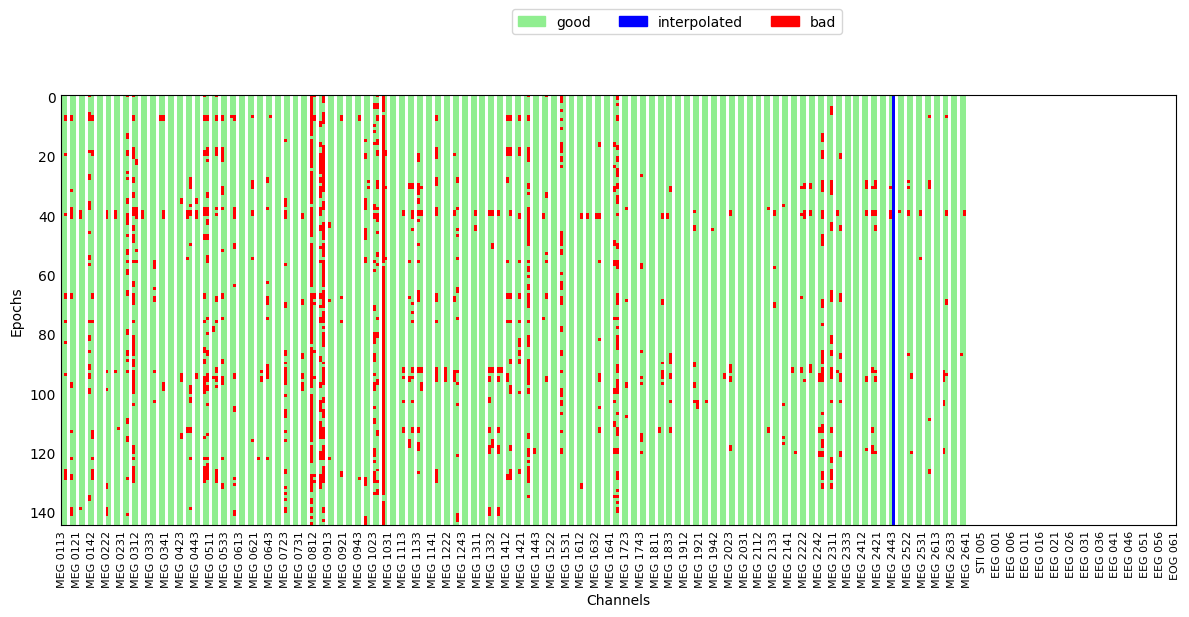

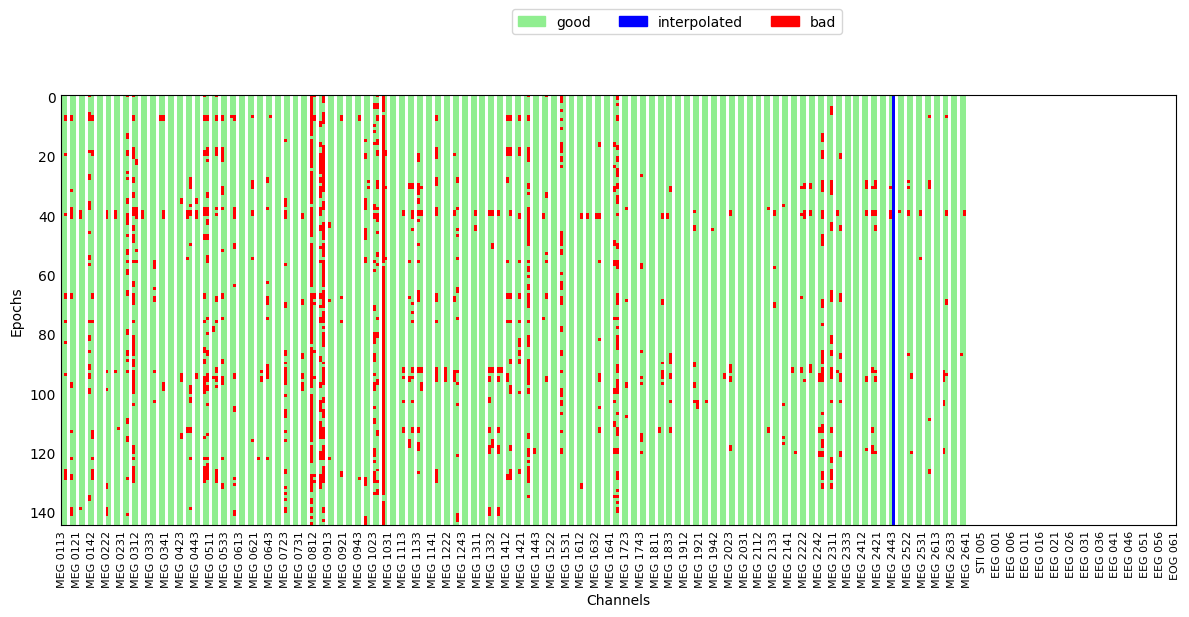

In [40]:
re_log.plot('vertical')

In [51]:
long_epochs

<Epochs | 145 events (all good), -0.999 – 1.998 s (baseline -0.999 – 0 s), ~190.8 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>

In [78]:
events_clean = epochs_clean.events
events_original = events

In [87]:
stop_events_ids = [3, 4]  # Define stop event IDs
new_events = []

epochs_numbers = []
stop_events = []
go_events = []

for epoch_index, event in enumerate(events_clean):

    # Find the index of the current event in events_original
    original_event_idx = np.where((events_original == event).all(axis=1))[0]

    if original_event_idx.size == 0:
        print(f"Warning: Event {event} not found in events_original!")
        continue  # Skip if event is not found

    original_event_idx = original_event_idx[0]  # Extract first occurrence

    # Ensure there's a next event
    if original_event_idx + 1 < len(events_original):
        next_event = events_original[original_event_idx + 1]

        # Check if the next event is a STOP event
        if next_event[2] in stop_events_ids:
            new_events.append(event)  # Only append once
            new_events.append(next_event)  # Only append once
            epochs_numbers.append(epoch_index)

            stop_events.append(next_event[0])
            go_events.append(event[0])
        else:
            print(f"Warning: Next of {event}: {next_event} not in STOP!")

new_events = np.array(new_events)

stop_events = np.array(stop_events)
go_events = np.array(go_events)

assert len(stop_events)==len(go_events)==len(epochs_numbers)

In [125]:
epochs

<Epochs | 145 events (all good), -0.999 – 1.998 s (baseline -0.999 – 0 s), ~190.8 MiB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 73>

In [119]:
import pandas as pd
epochs_clean_data = epochs_clean.get_data()[epochs_numbers]

assert len(epochs_clean_data)==len(epochs_numbers)

go_stop_dist = stop_events - go_events
sfreq = epochs.info['sfreq']

max_len = 0.8 # in sec
assert (go_stop_dist<=sfreq*max_len).all()

go_tp = int(abs(tmin)*sfreq)
data_df = pd.DataFrame({
    'GO events': go_events,
    'STOP events': stop_events,
    'GO-ST dist': go_stop_dist,
    'GO tp': [go_tp] * len(go_events),
    'STOP tp': go_tp + go_stop_dist,
    'Epoch': [epoch.tolist() for epoch in epochs_clean_data]
})

In [126]:
data_df

,GO events,STOP events,GO-ST dist,GO tp,STOP tp,Epoch
0,6994,7086,92,150,242,"[[8.5375208746595e-12, 8.064938718514267e-12, ..."
1,7192,7304,112,150,262,"[[-5.281491861452872e-12, -1.7243671390390212e..."
2,7413,7506,93,150,243,"[[-3.5656589191981803e-13, 1.287656818381235e-..."
3,7612,7709,97,150,247,"[[-1.6935250462395674e-12, -2.3275472788422747..."
4,7810,7916,106,150,256,"[[5.825442875909312e-13, 8.422784035999837e-13..."
...,...,...,...,...,...,...
130,37497,37607,110,150,260,"[[1.606054515272329e-12, 2.34735202472662e-12,..."
131,37718,37816,98,150,248,"[[-2.7032472413695895e-12, -3.0944736757416275..."
132,38106,38206,100,150,250,"[[-3.625147106212143e-12, -3.1033818787938073e..."
133,38302,38420,118,150,268,"[[-1.1499211191083397e-12, -3.535303000561371e..."


In [133]:
stop_epochs = []
stop_len = int(0.5*sfreq)
# Iterate over rows of the dataframe
for index, row in data_df.iterrows():
    epoch_data = np.array(row['Epoch'])  # Extract epoch data
    stop_idx = row['STOP tp']  # Get STOP event index (assuming it’s in time points)
    
    # Check if stop_idx is within bounds
    if stop_idx < epoch_data.shape[1]:
        stop_epoch = epoch_data[:, stop_idx:stop_idx+stop_len]  # Slice from stop_idx to end of the epoch
        stop_epochs.append(stop_epoch)
    else:
        print(f"Stop index {stop_idx} out of bounds for epoch at index {index}")

# Now, stop_epochs will contain the sliced epochs starting from STOP event
stop_epochs = np.array(stop_epochs)

In [138]:

zero_channel_average = np.mean(stop_epochs, axis=0)[0,:]
zero_channel_average.shape

(75,)

In [146]:
stop_epochs.shape

(135, 376, 75)

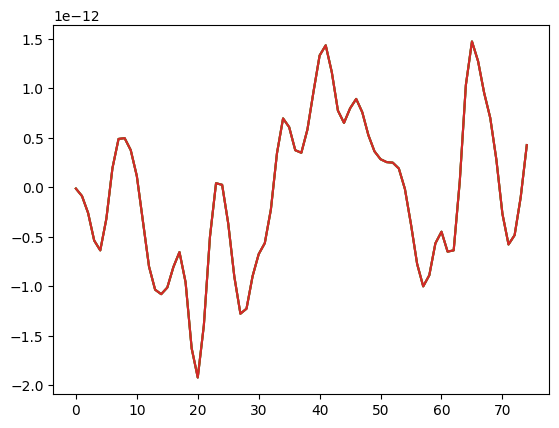

In [141]:
import matplotlib.pyplot as plt
plt.plot(zero_channel_average.flatten())

plt.show()

In [150]:
epochs_magic = mne.Epochs(epochs_clean, new_events, event_id_stop, tmin, tmax,
                    baseline=None, reject=None,
                    verbose=False, detrend=0, preload=True)

new_events

ValueError: The first argument to `Epochs` must be an instance of mne.io.BaseRaw

In [144]:
raw.info['bads'] = []
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False,
                       include=[], exclude=[])

raw.del_proj()  # remove proj, don't proj while interpolating
epochs_stop = mne.Epochs(raw, events, event_id_stop, tmin, tmax,
                    baseline=None, reject=None,
                    verbose=False, detrend=0, preload=True)

In [145]:
epochs_stop_data_2 = epochs_stop.get_data()

epochs_stop_data_2.shape

(143, 376, 76)

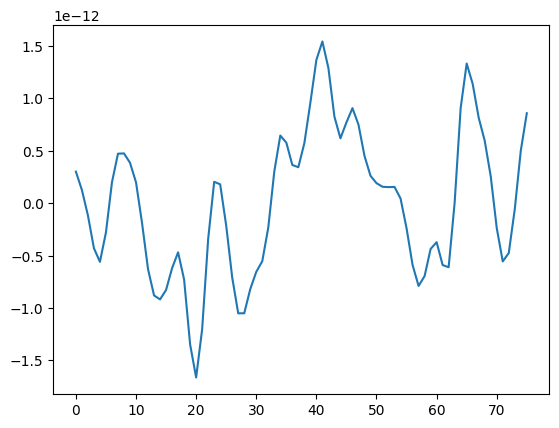

In [147]:
plt.plot(np.mean(epochs_stop_data_2, axis=0)[0,:])

plt.show()

In [64]:
stop_events = [3,4]
new_events = []
for epoch_index, event in enumerate(events_clean):
    print(event)
    event_tp = event[0]
    original_event_idx = np.where((events_original == event).all(axis=1))[0][0]
    next_event = events_original[original_event_idx + 1]
    print(next_event)

    if next_event[0] in stop_events:
        new_events.append((next_event, epoch_index))
        new_events.append((next_event, epoch_index))

0
2
4
6
8
10
12
14
16
19
21
23
25
27
29
31
33
35
38
40
42
44
46
48
50
52
54
56
58
61
63
65
67
69
71
73
75
77
82
84
86
88
90
92
94
96
98
101
103
105
107
109
111
113
115
117
122
124
126
128
130
132
134
136
138
140
142
145
147
149
151
153
155
157
159
161
166
168
170
172
174
176
178
180
182
184
187
189
191
193
195
197
199
201
206
208
210
212
214
216
218
220
222
224
229
231
233
235
237
239
241
243
245
248
250
252
254
256
258
260
262
264
269
271
273
275
277
279
281
283
285
289
291
293
295
297
299
301
303
305
307
309
312
314
316


In [ ]:
# 1. Create long epochs around Go trials with STOP signal
# 2. Extract events after cleaning (should be smaller subset than before cleaning but still relative to raw)
# 3. Iteare over these events creating new array of events: go and event right after this event from original events that have to be stop. If not, annotate that wrong
# 4. 
# 1. Look for the Go trials
# 2. After Go have to be STOP event

In [49]:
events

array([[ 6994,     0,     2],
       [ 7086,     0,     3],
       [ 7192,     0,     1],
       [ 7304,     0,     4],
       [ 7413,     0,     2],
       [ 7506,     0,     3],
       [ 7612,     0,     1],
       [ 7709,     0,     4],
       [ 7810,     0,     2],
       [ 7916,     0,     3],
       [ 8025,     0,     1],
       [ 8129,     0,     4],
       [ 8233,     0,     2],
       [ 8331,     0,     3],
       [ 8428,     0,     1],
       [ 8522,     0,     5],
       [ 8633,     0,     2],
       [ 8662,     0,    32],
       [ 8739,     0,     3],
       [ 8857,     0,     1],
       [ 8962,     0,     4],
       [ 9052,     0,     2],
       [ 9144,     0,     3],
       [ 9251,     0,     1],
       [ 9365,     0,     4],
       [ 9477,     0,     2],
       [ 9581,     0,     3],
       [ 9677,     0,     1],
       [ 9782,     0,     4],
       [ 9890,     0,     2],
       [ 9981,     0,     3],
       [10101,     0,     1],
       [10220,     0,     4],
       [10

In [50]:
epochs_clean.events

array([[ 6994,     0,     2],
       [ 7192,     0,     1],
       [ 7413,     0,     2],
       [ 7612,     0,     1],
       [ 7810,     0,     2],
       [ 8025,     0,     1],
       [ 8233,     0,     2],
       [ 8428,     0,     1],
       [ 8633,     0,     2],
       [ 8857,     0,     1],
       [ 9052,     0,     2],
       [ 9251,     0,     1],
       [ 9477,     0,     2],
       [ 9677,     0,     1],
       [ 9890,     0,     2],
       [10101,     0,     1],
       [10315,     0,     2],
       [10531,     0,     1],
       [10740,     0,     2],
       [10945,     0,     1],
       [11162,     0,     2],
       [11371,     0,     1],
       [11560,     0,     2],
       [11773,     0,     1],
       [11973,     0,     2],
       [12180,     0,     1],
       [12367,     0,     2],
       [12567,     0,     1],
       [12761,     0,     2],
       [12970,     0,     1],
       [13168,     0,     2],
       [13373,     0,     1],
       [13580,     0,     2],
       [13

In [48]:
epochs_clean.drop_log

((),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 ('IGNORED',),
 ('IGNORED',),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IGNORED',),
 (),
 ('IG

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


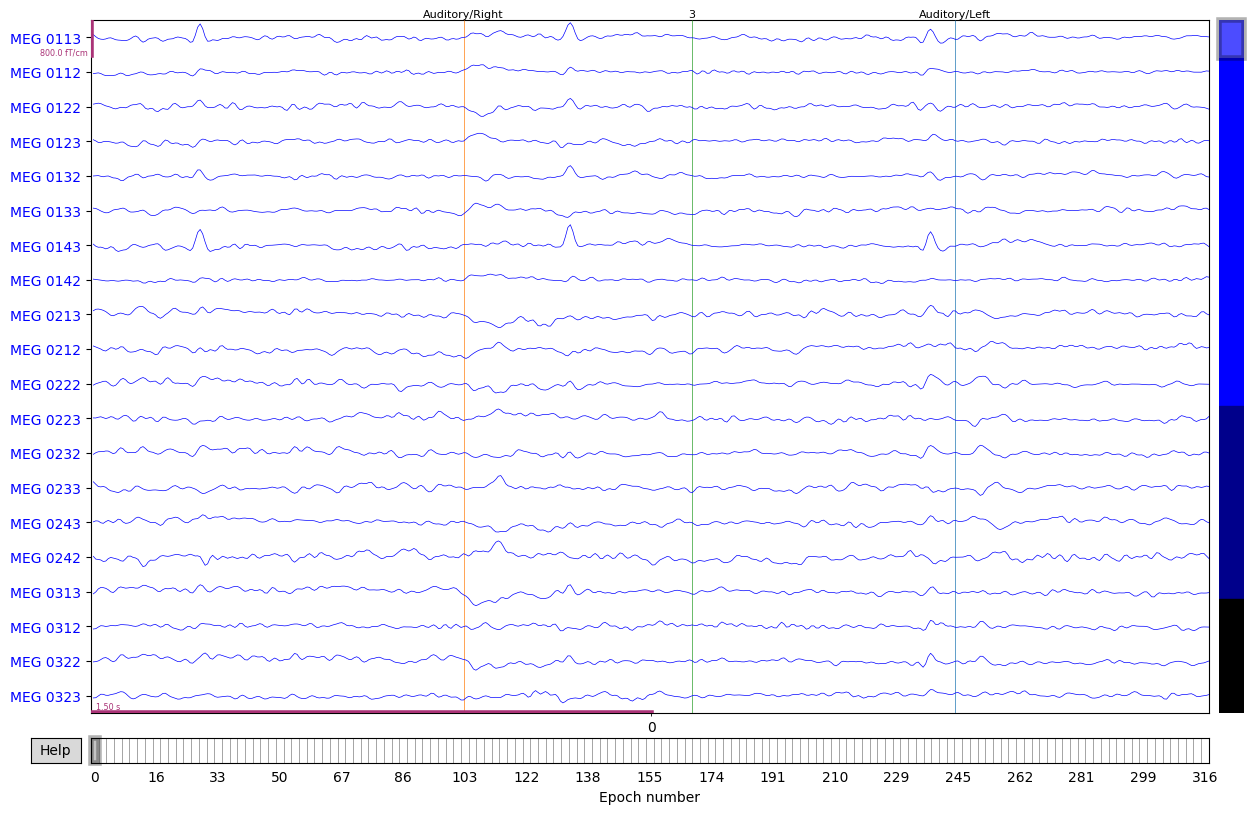

In [14]:
fig = epochs.plot(events=events, event_id=event_id, n_epochs=1)